In [1]:
%load_ext autotime

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from keras.applications.densenet import DenseNet169
from keras.utils import np_utils
from keras.utils import to_categorical
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras import optimizers
from keras import metrics
from keras import models

from keras.utils import plot_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras_tqdm import TQDMNotebookCallback
from ipywidgets import IntProgress, HTML, HBox

from pathlib import Path
import pickle

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


time: 1.9 s


In [3]:
import logging

log = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO)

time: 709 µs


In [4]:
import tensorflow as tf
from keras import backend as K
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
K.set_session(sess)

time: 2.35 s


In [5]:
import utils # importing from our utils functions

time: 4.38 s


In [6]:
x_train, y_train, x_test, y_test = utils.read_mura_pickle()
x_train = utils.normalize_pixels(x_train)
x_test = utils.normalize_pixels(x_test)

INFO:utils.utils:loading data/MURA-v1.1/x_train.pkl
INFO:utils.utils:loading data/MURA-v1.1/y_train.pkl
INFO:utils.utils:loading data/MURA-v1.1/x_valid.pkl
INFO:utils.utils:loading data/MURA-v1.1/y_valid.pkl


time: 15.8 s


In [7]:
x_train.shape

(36808, 256, 256)

time: 2.23 ms


In [8]:
size = x_train.shape[1]
x_train = x_train.reshape(x_train.shape[0], size, size, 1)
x_test = x_test.reshape(x_test.shape[0], size, size, 1)

time: 923 µs


# Train Submodel

In [9]:
datagen = ImageDataGenerator(
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=[1.0, 1.2],
    fill_mode = 'constant',
    cval=0,
    horizontal_flip=True,
    vertical_flip=True)

time: 1.44 ms


In [10]:
datagen.fit(x_train)

time: 5.78 s


In [29]:
with tf.device('/GPU:2'):
    densenet = DenseNet169(input_shape=(256, 256, 1), classes=1, weights=None, include_top=False)
    for layer in densenet.layers:
        if isinstance(layer, layers.Convolution2D):
            layer.trainable = False
    model = models.Model(input=densenet.input, output=layers.Dense(1, activation='sigmoid')(layers.Flatten()(densenet.output)))

time: 29.8 s


In [36]:
starting_epoch = 0
train_round = 0
batch_size = 16
epochs_per_eval = 10
epochs_per_save = 30
total_epochs = 90
optimizer = 'adam'
lr = 0.001
train_history = {'loss': [], 'binary_accuracy': [], 'learn_rate': []}
val_per_image_history = {'accuracy': [], 'kappa': [], 'precision': [], 'recall': []}
val_per_study_history = {'accuracy': [], 'kappa': [], 'precision': [], 'recall': []}
model_name='4_0_try_densenet169'

time: 1.77 ms


In [37]:
def weighted_binary_crossentropy(p1):
    '''
    p1 is the proportion of ones in population
    '''
    w0 = K.variable(p1)
        
    def loss(y_true, y_pred):
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = -(1 - w0) * y_true * K.log(y_pred) - w0 * (1 - y_true) * K.log(1 - y_pred)
        loss = K.sum(loss, -1)
        return loss
    
    return loss

time: 2.16 ms


In [38]:
p1 = y_train.mean()

time: 995 µs


In [39]:
# clr = utils.clr.CyclicLR(mode='triangular2')
# opt = optimizers.SGD(nesterov=True)
opt = optimizers.Adam()

time: 12.3 ms


In [40]:
progress = TQDMNotebookCallback(leave_inner=True, leave_outer=True) 

time: 895 µs


INFO:__main__:executing epochs 1-10


INFO:utils.mura_metrics:Accuracy: 0.6183922427275571
INFO:utils.mura_metrics:Kappa: 0.22619456216945025
INFO:utils.mura_metrics:Precision: 0.6424632352941176
INFO:utils.mura_metrics:Recall: 0.4568627450980392


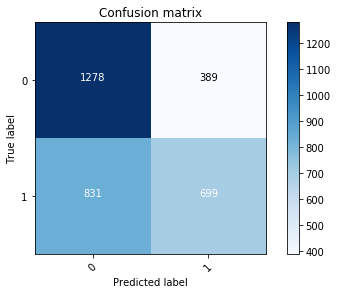

INFO:utils.mura_metrics:Accuracy: 0.640533778148457
INFO:utils.mura_metrics:Kappa: 0.2434600311242349
INFO:utils.mura_metrics:Precision: 0.6731391585760518
INFO:utils.mura_metrics:Recall: 0.38661710037174724


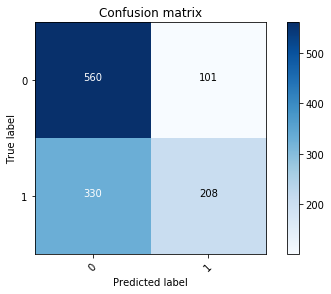

INFO:__main__:Saving evaluation metrics history...
INFO:__main__:executing epochs 11-20


INFO:utils.mura_metrics:Accuracy: 0.6359086643728495
INFO:utils.mura_metrics:Kappa: 0.26996789380118486
INFO:utils.mura_metrics:Precision: 0.6216755319148937
INFO:utils.mura_metrics:Recall: 0.6111111111111112


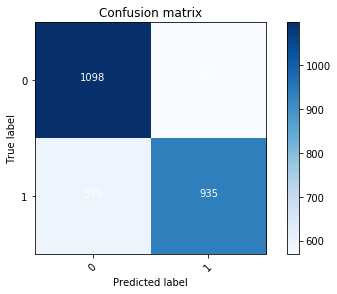

INFO:utils.mura_metrics:Accuracy: 0.6705587989991659
INFO:utils.mura_metrics:Kappa: 0.3260680555931064
INFO:utils.mura_metrics:Precision: 0.652452025586354
INFO:utils.mura_metrics:Recall: 0.5687732342007435


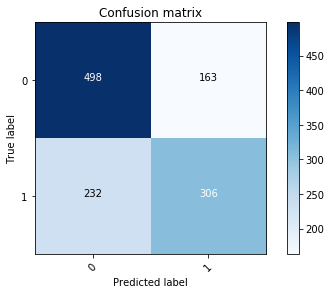

INFO:__main__:Saving evaluation metrics history...
INFO:__main__:executing epochs 21-30


INFO:utils.mura_metrics:Accuracy: 0.6371598373475132
INFO:utils.mura_metrics:Kappa: 0.2797933055803919
INFO:utils.mura_metrics:Precision: 0.5982996811902231
INFO:utils.mura_metrics:Recall: 0.7359477124183007


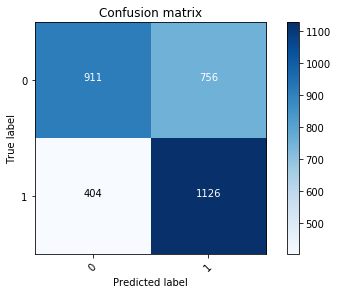

INFO:utils.mura_metrics:Accuracy: 0.6538782318598833
INFO:utils.mura_metrics:Kappa: 0.31123335303538485
INFO:utils.mura_metrics:Precision: 0.5977742448330684
INFO:utils.mura_metrics:Recall: 0.6988847583643123


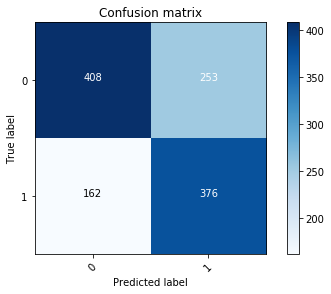

INFO:__main__:Saving Model to trained_models/4_0_try_densenet169_30.h5...
INFO:__main__:Saving evaluation metrics history...
INFO:__main__:executing epochs 31-40


INFO:utils.mura_metrics:Accuracy: 0.653112292774476
INFO:utils.mura_metrics:Kappa: 0.31348501515456323
INFO:utils.mura_metrics:Precision: 0.6056196688409433
INFO:utils.mura_metrics:Recall: 0.7888888888888889


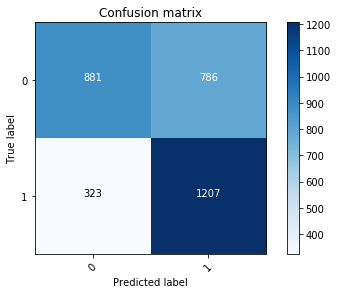

INFO:utils.mura_metrics:Accuracy: 0.6713928273561302
INFO:utils.mura_metrics:Kappa: 0.34929944517600664
INFO:utils.mura_metrics:Precision: 0.6094224924012158
INFO:utils.mura_metrics:Recall: 0.7453531598513011


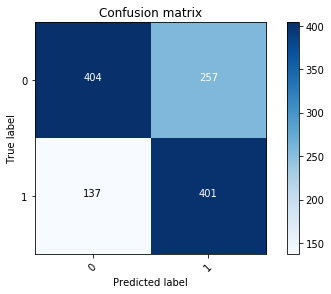

INFO:__main__:Saving evaluation metrics history...
INFO:__main__:executing epochs 41-50


INFO:utils.mura_metrics:Accuracy: 0.6778229590240851
INFO:utils.mura_metrics:Kappa: 0.3556718278248585
INFO:utils.mura_metrics:Precision: 0.65625
INFO:utils.mura_metrics:Recall: 0.6862745098039216


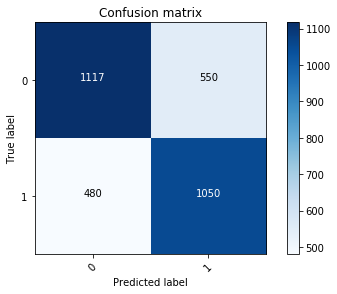

INFO:utils.mura_metrics:Accuracy: 0.6914095079232694
INFO:utils.mura_metrics:Kappa: 0.3738726659421619
INFO:utils.mura_metrics:Precision: 0.6627906976744186
INFO:utils.mura_metrics:Recall: 0.6356877323420075


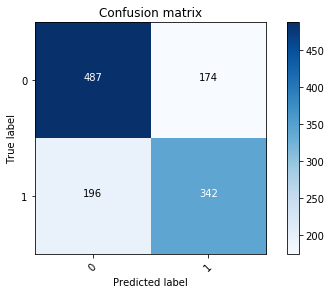

INFO:__main__:Saving evaluation metrics history...
INFO:__main__:executing epochs 51-60


KeyboardInterrupt: 

time: 7h 11min 48s


In [41]:
while (train_round+1) * epochs_per_eval + starting_epoch <= total_epochs:
    log.info(f'executing epochs {train_round * epochs_per_eval + 1 + starting_epoch}-{(train_round+1) * epochs_per_eval + starting_epoch}')
    
#     if train_round * epochs_per_eval + 1 + starting_epoch >= 10:
#         if np.mean(train_history['loss'][-10:-5]) < np.mean(train_history['loss'][-5:]): # if no improvements in 5 epochs
#             if optimizer == 'adam':
#                 log.info(f'switching to SGD with lr={lr}')
#                 optimizer = 'sgd'
#             else:
#                 log.info(f'reducing SGD learn rate from {lr} to {lr * 0.8}')
#                 lr = lr * 0.8
#             opt = optimizers.SGD(lr=lr, momentum=0.9, nesterov=True)
#         else:
#             if optimizer == 'adam':
#                 opt = optimizers.Adam(lr=lr)
#             else:
#                 opt = optimizers.SGD(lr=lr, momentum=0.9, nesterov=True)
#     else:
#         opt = optimizers.Adam(lr=lr)

    model.compile(
        loss=weighted_binary_crossentropy(p1),
        optimizer=opt,
        metrics=[metrics.binary_accuracy])
    
    model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                           steps_per_epoch =  int(np.round(len(x_train) / batch_size)), 
                           epochs=epochs_per_eval, verbose=0,
                           callbacks=[progress])
                           # callbacks=[clr, TQDMNotebookCallback()])
    
    # train_history['learn_rate'].extend(clr.history['lr'])
    train_history['loss'].extend(model.history.history['loss'])
    train_history['binary_accuracy'].extend(model.history.history['binary_accuracy'])
    
    y_valid_hat = model.predict(x_test)
    true_label = np.round(y_test)
    pred_label = np.round(y_valid_hat)
    evaluate = utils.MURAMetrics(true_label, pred_label)
    
    per_image_metrics = evaluate.report_by_image()
    for key in per_image_metrics:
        val_per_image_history[key].append(per_image_metrics[key])
    
    per_study_metrics = evaluate.report_by_study()
    for key in per_image_metrics:
        val_per_study_history[key].append(per_study_metrics[key])
    
    cur_epoch = (train_round + 1) * epochs_per_eval
    if cur_epoch % epochs_per_save == 0:
        log.info(f'Saving Model to trained_models/{model_name}_{cur_epoch + starting_epoch}.h5...')
        model.save(f'./trained_models/{model_name}_{cur_epoch + starting_epoch}.h5')
    
    log.info('Saving evaluation metrics history...')
    with open(f'./trained_models/{model_name}_train_history.pkl', 'wb') as pkl_file:
        pickle.dump(train_history, pkl_file)
    with open(f'./trained_models/{model_name}_val_per_image_history.pkl', 'wb') as pkl_file:
        pickle.dump(val_per_image_history, pkl_file)
    with open(f'./trained_models/{model_name}_val_per_study_history.pkl', 'wb') as pkl_file:
        pickle.dump(val_per_study_history, pkl_file)
    
    train_round += 1